## CardioPredict: Assessing Heart Disease Risk through Logistic Regression Analysis
_CardioPredict harnesses the power of logistic regression to analyze key health indicators and provide a predictive model for assessing the risk of coronary heart disease in individuals._

Data source: https://paulblanche.com/files/DataFramingham.html

by Joel Wu, Sandra Gross, He Ma and Doris Wang (DSCI 522 Group 10 Milestone 1)

2023/11/15

In [57]:
#Imports
import numpy as np
import pandas as pd
import imblearn
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt


import sys
# Import the count_classes function from the src folder
sys.path.append('..')
from src.run_knn_analysis import run_knn_analysis
from sklearn.metrics import confusion_matrix
from src.create_pairwise_scatter_plot import create_pairwise_scatter_plot
from src.logistic_regression_evaluation import evaluate_logistic_regression


### Summary
In the analysis we examine the development and evaluation of two models, Logistic Regression and k-Nearest Neighbours (kNN), to predict the risk of coronary heart disease using the Framingham Heart Study dataset. The Logistic Regression model, optimized through hyperparameter tuning, demonstrated a modest test accuracy of 55.3% but had a high recall for class 1 (indicating disease presence) at 84%. However, its precision was low, indicating a high rate of false positives. The kNN model, selected based on cross-validation, initially showed a higher accuracy of approximately 79% but a very low recall of 5.17%, indicating many false negatives. After applying oversampling to address class imbalance, the kNN model’s recall improved significantly to 51.7%, though accuracy decreased to 63.7%. The report concludes that while Logistic Regression is preferable due to its higher recall, both models show limited accuracy. Further investigation into the dataset’s features and more refined preprocessing are recommended for improved model performance. 
This study could encourage collaborations between data scientists, healthcare professionals, and epidemiologists to develop more robust models for disease prediction

### Introduction
Heart disease remains the leading cause of death worldwide, with an estimated 17.9 million lives lost annually (World Health Organization, 2023). The global fatalities from cardiovascular diseases (CVDs) have risen from about 12.1 million in 1990 to 18.6 million in 2019 (World Heart Federation, 2023). Identifying high-risk individuals and providing timely treatment is critical to reducing premature mortality from CVDs.

Professor Fausto Pinto states, "Up to 80 percent of premature heart attacks and strokes are preventable... Quality data plays a pivotal role in shaping effective policies. The opportunity to expedite efforts in reducing premature mortality from non-communicable diseases (NCDs) by one-third by 2030 remains attainable." (World Heart Federation, 2023).

Professor Fausto Pinto highlights the importance of data-driven approaches in predicting cardiovascular disease (CVD) risk. Leveraging the famous Framingham Heart Study's data, our project examines the potential of machine learning classification methods to assess heart disease risk and identify the risk factors. The dataset contains 1,363 records and includes variables such as age, gender, blood pressure, cholesterol levels, and smoking habits, analyzed to predict the likelihood of developing heart disease. Given that many cardiovascular conditions present no initial symptoms and are preventable through lifestyle modifications (World Health Organization, 2023), an algorithm capable of accurately detecting at-risk individuals can be pivotal. Early detection is paramount to providing early interventions, which may include lifestyle counseling and proactive medication management, thereby improving patient outcomes.

### Data
The CardioPredict project utilizes data from the renowned Framingham Heart Study (https://clinicaltrials.gov/study/NCT00005121), a pivotal cohort study initiated in 1948 in Framingham, Massachusetts. This extensive study, initially planned for 20 years, focused on residents aged 30-59 and aimed to identify common factors contributing to cardiovascular disease. Our dataset, derived from this study, encompasses a comprehensive collection of health metrics from 1,363 individuals, meticulously recorded and analyzed to gauge the risk of developing heart disease.
Key variables in this dataset include age, gender, systolic and diastolic blood pressure (SBP and DBP), cholesterol levels, Framingham relative weight (FRW), and smoking habits (measured as cigarettes per day). These variables offer a multifaceted view into each individual's health status, providing a robust foundation for our predictive analysis. For example, 'sex' is categorized into Female or Male, 'AGE' represents the age of individuals in years, 'FRW' indicates the Framingham relative weight percentage at baseline ranging from 52 to 222, 'SBP' and 'DBP' measure blood pressure in mmHg, 'CHOL' shows cholesterol levels in mg/100ml, and 'CIG' quantifies cigarette consumption per day. The 'disease' variable,which serves as out target variable, marks the occurrence of coronary heart disease during the study, noted as 1 for occurrence and 0 otherwise.
Further insights into the Framingham Heart Study and its historical significance can be explored through resources like Wikipedia. The complete dataset utilized for the CardioPredict project is accessible here: https://paulblanche.com/files/DataFramingham.html


| Variable | Explanation |
|----------|-------------|
| sex      | sex (Female/Male) |
| AGE      | Age in years |
| FRW      | "Framingham relative weight" (pct.) at baseline (52-222) |
| SBP      | systolic blood pressure at baseline mmHg (90-300) |
| DBP      | diastolic blood pressure at baseline mmHg (50-160) |
| CHOL     | cholesterol at baseline mg/100ml (96-430) |
| CIG      | cigarettes per day at baseline (0-60) |
| disease  | 1 if coronary heart disease occurred during the follow-up, 0 otherwise |

### Exploratory Data Analysis (EDA)

In [58]:
# 1. import data and split into train and test
df = pd.read_csv("data/framingham.csv")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df

,AGE,FRW,SBP,DBP,CHOL,CIG,sex,disease
723,50,118.0,160,100,334,20.0,Female,0
749,52,95.0,135,85,296,20.0,Male,0
66,48,90.0,120,80,200,15.0,Male,0
240,55,118.0,190,110,220,20.0,Female,0
246,47,83.0,140,78,170,20.0,Male,1
...,...,...,...,...,...,...,...,...
1147,51,118.0,124,78,242,0.0,Male,0
106,53,116.0,124,72,142,30.0,Male,0
1041,51,76.0,96,68,265,20.0,Male,0
1122,49,100.0,120,84,201,20.0,Male,0


In [59]:
train_df.describe()

,AGE,FRW,SBP,DBP,CHOL,CIG,disease
count,1090.00000,1083.000000,1090.000000,1090.000000,1090.000000,1089.000000,1090.000000
mean,52.40367,104.779317,148.254128,90.294495,234.098165,8.019284,0.192661
std,4.81431,17.389638,28.460831,14.224762,46.241893,11.575781,0.394570
min,45.00000,52.000000,90.000000,50.000000,96.000000,0.000000,0.000000
25%,48.00000,94.000000,130.000000,80.000000,200.000000,0.000000,0.000000
50%,52.00000,102.000000,142.000000,90.000000,229.500000,0.000000,0.000000
75%,56.00000,113.000000,160.000000,99.500000,263.000000,20.000000,0.000000
max,62.00000,222.000000,300.000000,160.000000,430.000000,60.000000,1.000000


In [60]:
# 2. check missing
print(train_df.info())
print(train_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 1090 entries, 723 to 1346
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AGE      1090 non-null   int64  
 1   FRW      1083 non-null   float64
 2   SBP      1090 non-null   int64  
 3   DBP      1090 non-null   int64  
 4   CHOL     1090 non-null   int64  
 5   CIG      1089 non-null   float64
 6   sex      1090 non-null   object 
 7   disease  1090 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 76.6+ KB
None
AGE        0
FRW        7
SBP        0
DBP        0
CHOL       0
CIG        1
sex        0
disease    0
dtype: int64


'FRW' has 7 null values, 'CIG' has 1 null value, indicating missing data in these columns. The presence of null values in 'FRW' and 'CIG' suggests the need for handling missing data, either by filling in these gaps or excluding these entries.

In [61]:
# 3. distribution of target feature
target_chart = alt.Chart(df).mark_bar().encode(
    x='disease:O',
    y=alt.Y('count():Q', axis=alt.Axis(title='Count')),
    text=alt.Text('count():Q')
).properties(
    height=200,
    width=200,
    title="Figure 1: Distribution of Disease Occurrence"
)

target_chart = target_chart + target_chart.mark_text(
    align='center',
    baseline='bottom',
    dy=-5
)

target_chart

alt.LayerChart(...)

There are 1,095 individuals without heart disease and 268 individuals with heart disease, indicating a higher prevalence of non-disease cases in the sample and high class imbalance.

In [62]:
# 4. distribution of numerical features
numerical_features = ['AGE', 'FRW', 'SBP', 'DBP', 'CHOL',	'CIG']

numerical_chart = alt.Chart(train_df).transform_calculate(
    disease_label="datum.disease == 1 ? '1: have heart disease' : '0: do not have heart disease'"
).mark_bar(opacity=0.8).encode(
    alt.X(alt.repeat('repeat'), type='quantitative', bin=alt.Bin(maxbins=20)),
    alt.Y('count()', stack=None),
    color=alt.Color('disease_label:N', legend=alt.Legend(title="Disease Status"))
).properties(
    width=200,
    height=200
).repeat(
    repeat=numerical_features, 
    columns=3
).properties(
    title='Figure 2: Age and Health Indicators Exhibit Elevated Heart Disease'
)

numerical_chart

alt.RepeatChart(...)

The distributions displayed in the charts indicate that most of the variables (AGE, FRW, SBP, DBP, CHOL, CIG) show a clear differentiation between individuals with heart disease (1) and those without (0), especially for SBP, DBP, and CHOL. Individuals with heart disease tend to have higher systolic blood pressure (SBP), diastolic blood pressure (DBP), and cholesterol (CHOL) levels, while age, relative weight (FRW), and cigarette consumption (CIG) do not show as pronounced a difference between the two groups. Most of the features, except for CIG and AGE are roughly normally distributed.

In [63]:
# 5. correlation matrix
correlation_matrix = train_df.select_dtypes(include=['number', 'bool']).corr('spearman')
mask = np.eye(correlation_matrix.shape[0], dtype=bool)
correlation_matrix = correlation_matrix.where(~mask, np.nan)

correlation_matrix.style.background_gradient(cmap='coolwarm').set_caption('Figure 3: Correlation Matrix of the Features')

,AGE,FRW,SBP,DBP,CHOL,CIG,disease
AGE,nan,0.092876,0.179298,0.036477,0.093347,-0.162217,0.130144
FRW,0.092876,nan,0.281357,0.322311,0.072872,-0.231591,0.055237
SBP,0.179298,0.281357,nan,0.771926,0.131841,-0.095482,0.183792
DBP,0.036477,0.322311,0.771926,nan,0.111562,-0.077424,0.157544
CHOL,0.093347,0.072872,0.131841,0.111562,nan,-0.059533,0.050861
CIG,-0.162217,-0.231591,-0.095482,-0.077424,-0.059533,nan,0.053993
disease,0.130144,0.055237,0.183792,0.157544,0.050861,0.053993,nan


Systolic and diastolic blood pressure (SBP and DBP) show a strong positive correlation. Additionally, there is a notable positive correlation between SBP and the occurrence of disease, as well as between DBP and disease, age and disease, while cigarette smoking (CIG) is negatively correlated with Framingham relative weight (FRW) and cholesterol levels (CHOL).

In [64]:
# 6. pairwise scatter plots
pairwise_chart = create_pairwise_scatter_plot(train_df, numerical_features)
pairwise_chart

alt.RepeatChart(...)

Systolic and diastolic blood pressure (SBP and DBP) show a strong linear relationship. Additionally, the color differentiation indicates potential trends between these variables and the presence of heart disease, with some variables like SBP exhibiting clusters that may correlate with higher instances of the disease.

In [65]:
#Distribution of the categorical variable 
alt.Chart(train_df, title = "Figure 5: Distribution of the sex variable").mark_bar().encode(
    y="sex",
    x= "count()",
    color = "disease:N"
)

alt.Chart(...)

The distribution of the two genders appears to be approximately equal, with a similar number of observations being sick in each group.

### Analysis

In [66]:
#Separate target value form train and test set 
X_train = train_df.drop(columns="disease")
y_train = train_df["disease"]

X_test = test_df.drop(columns=["disease"])
y_test = test_df["disease"]

#### Preprocessing Data
All the features appear to exhibit some relevance in predicting whether a patient has the disease or not. Therefore, we will refrain from excluding any feature from our model.

##### Numeric features:
- AGE
- FRW
- SBP
- DBP
- CHOl
- CIG
  
To account for some of the missing values in the numeric columns, we need to do imputation. Due to the skewed distribution of specific features, especially CIG, it's recommended to use the median of the corresponding columns rather than the mean for imputing missing values.
Moreover, given the varied scales of the features, it is essential to apply a StandardScaler.

In [67]:
#Create pipeline for numeric features 
numeric_pipe = make_pipeline(
    SimpleImputer(strategy = "median"), StandardScaler()
)

##### Categorical Feature: 
- SEX
  
In this data set, gender is considered a binary feature. Consequently, we can employ `OneHotEncoding` with the `drop="if_binary"`
 argument, resulting in the creation of a single binary-encoded column instead of two. Since this column does not have any missing value, there is no need for Imputation.

In [68]:
numeric_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = ["sex"]

In [69]:
#Create Column Transformer 
preprocessor = make_column_transformer(    
    (numeric_pipe, numeric_features),  
    (OneHotEncoder(drop="if_binary", sparse_output = False), categorical_features)
)

#### Model Selection
##### Logistic Regression
We are interested in determining whether a patient suffers from a disease or not, which constitutes a classification problem. To address this, we employ a `Logistic Regression model`, which is a linear model. Considering the substantial class imbalance and the fact that we are rather concerned about false negatives in the medical context — as we aim to minimize instances where patients miss critical treatment — we should make use of the argument `class_weight` argument. By trying out different values for the `class_weight`, we see that 1:6 seems to gives as a satisfactory result for our recall-precision trade off. And In order to find the best model and avoid under-/overfitting we want to improve the hyperparameter C of the LogisticRegression via Gridsearch.


In [70]:
cm, report, gs, gs_res = evaluate_logistic_regression(X_train, y_train, 
                                                      X_test, y_test, 
                                                      numeric_features, categorical_features)

#### The result of the GridSearch for the hyperparameter C of LogisticRegression.

In [71]:
print(f'Best Parameters:  {gs.best_params_}')
print(f"Best Score:  {gs.best_score_}")
print(f"Test Set Score: {gs.score(X_test, y_test)}")
gs_res.style.set_caption('<p style="text-align:left;">Table 1: Results of Hyperparameter Optimization via Gridsearch</p>')

Best Parameters:  {'logisticregression__C': 1000.0}
Best Score:  0.5192660550458716
Test Set Score: 0.5531135531135531


,rank_test_score,param_logisticregression__C,mean_train_score,std_train_score,mean_test_score,std_test_score
7,1,1000.000000,0.526835,0.025495,0.519266,0.032097
8,1,10000.000000,0.526835,0.025495,0.519266,0.032097
9,1,100000.000000,0.526835,0.025495,0.519266,0.032097
4,4,1.000000,0.526835,0.025495,0.518349,0.030150
5,4,10.000000,0.526835,0.025495,0.518349,0.030703
6,4,100.000000,0.526835,0.025495,0.518349,0.030703
3,7,0.100000,0.516514,0.026694,0.511927,0.027767
2,8,0.010000,0.471789,0.022782,0.458716,0.021121
1,9,0.001000,0.256422,0.014857,0.254128,0.022397
0,10,0.000100,0.192661,0.000000,0.192661,0.000000


##### Result on test data

For test data, we get an accuracy of 53.1%. The accuracy is a metric which is defined to be the fraction of correct predictions divded by all predictions. 
This implies, that in 53% of our test examples we predict the target correctly, which seems to be pretty low. However, as mentioned above we should be careful when interpreting this metric especially in the case of the class imbalance, which is given in our data set. Instead, we should examine how the model predictions are correct and incorrect, and look at other metrices.

##### Visualization of Predictions Results

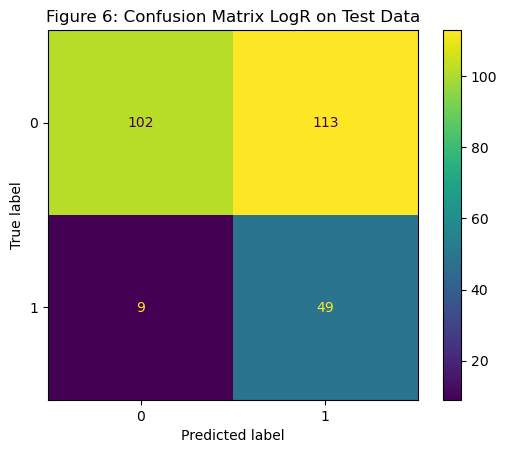

In [72]:
#Create a Confusion Matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.title('Figure 6: Confusion Matrix LogR on Test Data')
plt.show()

In [73]:
#Classification report
print('Table 2: Classification Report for Test Data')
print(report)

Table 2: Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.92      0.47      0.63       215
           1       0.30      0.84      0.45        58

    accuracy                           0.55       273
   macro avg       0.61      0.66      0.54       273
weighted avg       0.79      0.55      0.59       273



In the graphic and the classification report we can see that we have a very high recall score (0.84) for the test data, which is desired in our scenario. However, the precision score with a value of 0.30 is pretty low as we have many false positives (Type I error) rather than false negatives, type II errors. In our Confusion Matrix above we can see that out of our 215 negative cases we predict 113, so more than half of them, to be positive. On the other hand, there is small amount of sick patients, which we predict to be negative. With an accuracy value of 0.55, the performance appears to be relatively low. So the data may be not be well suited for applying a linear model. Thus, we are interested in exploring a different model for predicting whether a patient suffers from a disease or not.

##### k-Nearest Neighbours 

In the following, we apply an analogy-based model to predict the class of the data point by finding the “closest” data points in the training set and taking the majority vote of the k nearest neighbours. First, we use cross validation to find the best value for `k`. 

In [25]:
#Find the best k for knn
param_grid = {"n_neighbors": np.arange(1, 50, 5)}
run_knn_analysis(X_train, y_train, param_grid, preprocessor)

,n_neighbors,mean_train_score,mean_cv_score,std_cv_score,std_train_score
0,1,1.000000,0.707339,1.373085e-02,0.000000e+00
1,6,0.822018,0.800917,1.802466e-02,4.128440e-03
2,11,0.816514,0.793578,1.196184e-02,3.323710e-03
3,16,0.806651,0.802752,6.487218e-03,3.946021e-03
4,21,0.805963,0.800917,6.222321e-03,1.521388e-03
5,26,0.807339,0.805505,3.669725e-03,1.450586e-03
6,31,0.807110,0.804587,3.669725e-03,8.581783e-04
7,36,0.807569,0.806422,1.834862e-03,4.587156e-04
8,41,0.807339,0.807339,1.110223e-16,1.110223e-16
9,46,0.807339,0.807339,1.110223e-16,1.110223e-16


We can see that k=1 performs best. However, this model would suffer from overfitting, as indicated by the high train_score and the high gap between the cv_score and the train_score. Thus, we use the second best performing k=6 for our model.

In [20]:
#Create pipeline
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=6))
pipe_knn.fit(X_train, y_train)
pipe_knn.score(X_test,y_test)


0.7875457875457875

In [21]:
recall_score(y_test, pipe_knn.predict(X_test), pos_label=1)

0.05172413793103448

In this case, we get a decent  accuracy of approximately 79 %. However, the recall score is really low (0.05), which implies that we have many false negatives/type II errors, which is undesirable in the medical context. The primary reason for this may lie in the imbalanced data set, that contains much more negative cases than positive ones and which affects the prediction of our model, which is based on the closest neighbors. In order to create a model which scores better in the recall, we could use `oversampling`. This technique tries to encounter class imbalance by randomly duplicating examples from the minority class and adding them to the training data set.

In [22]:
#Oversampling
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
pipe_knn.fit(X_resampled, y_resampled)
pipe_knn.score(X_test,y_test)

0.6373626373626373

In [23]:
recall_score(y_test, pipe_knn.predict(X_test), pos_label=1)

0.5172413793103449

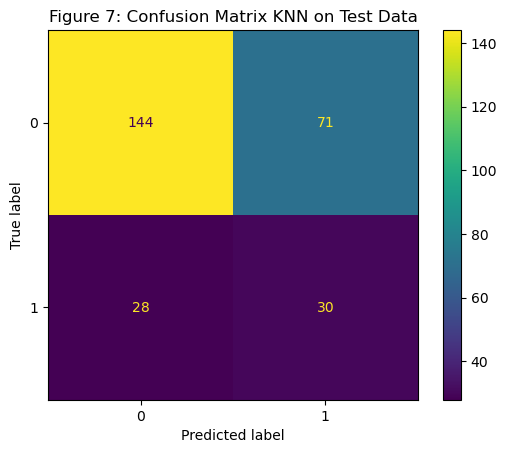

In [26]:
#Create a Confusion Matrix for KNN
ConfusionMatrixDisplay.from_predictions(
    y_test,  # true class labels
    pipe_knn.predict(X_test),  # predicted class labels
)
plt.title('Figure 7: Confusion Matrix KNN on Test Data')
plt.show()

Applying the over_sampling technique resulted in a significant boost in recall, albeit at the expense of a decrease in accuracy from 78% to 64%. This indicates that the current model configuration may not be optimal. In comparison to our Logistic Regression above we have less false positive cases, but more false negative ones: We predict almost half of the sick patients to be non sick, which may be harmful in a clinical context. 

### Results

#### Summary of Findings

Logistic Regression:

- The model was adjusted to prioritize minimizing false negatives, which is crucial in medical diagnostics.
- A specific parameter (C) was determined using Gridsearch to optimize the model.
- The optimized logistic regression model achieved an accuracy of 53.1%.
- It exhibited high recall but low precision, indicating it was better at identifying true cases of CHD but also had a higher rate of false positives.

k-Nearest Neighbors (k-NN):

- The initial k-NN model showed a decent accuracy of around 79% but suffered from very low recall, leading to a significant number of false negatives.
- To address the issue of class imbalance in the dataset, oversampling was applied.
- After oversampling, the recall of the model improved notably, indicating fewer false negatives. However, this improvement came at the cost of reduced overall accuracy (64%).

Based on the results of these models, we would rather suggest to employ `Logistic Regression` with the class_weight argument due to its superior recall. However, it's important to note that both model are poorly performing on the accuracy score. Thus, for subsequent analyses, it becomes imperative to delve deeper into the specific features and their contributions to predictions or conduct additional data preprocessing to refine the model's overall effectiveness.
Additionally, he underlying cause of this unsatisfactory' result is likely rooted in the inherent characteristics of the data set. The features may not be too informative or sufficient for predicting whether a patient suffers from a coronary heart disease. The features provide more of an indication of whether a person is at risk for coronary heart disease. Therefore, it would probably result in a better model to have multiple variables in the target, indicating whether a patient already shows initial signs of the disease, rather than using a binary classification model.

### Discussion
#### Discussion on Expectations

In medical diagnostics, especially for critical conditions like coronary heart disease, the priority is often to minimize false negatives as we aim to minimize instances where patients miss critical treatment. Thus, in our analysis we tried different measures to increase the recall. However, the relatively moderate accuracy levels (53.1% for logistic regression and 64% for KNN after oversampling) might be lower than what one might expect for medical diagnostic tools. This could result from the imbalance in class distribution and needs to be evaluated within the specific application to determine whether this low accuracy is acceptable. Such an evaluation should also contains an estimation of the incurred costs, that arise by having false positive/false negatives and approach to minimize these costs.

#### Impact of Findings

1. Medical Practice and Patient Care:

The models can help in identifying individuals at higher risk of CHD, enabling early intervention and potentially more effective treatment strategies. It could also lead to more personalized and effective healthcare, as you can tailor patient care based on individual risk profiles, informed by these predictive models.

2. Healthcare Policy and Preventive Strategies:

These findings can inform healthcare policies focused on preventive measures for high-risk groups, potentially leading to public health initiatives that target modifiable risk factors for CHD.
Healthcare systems could use such models to allocate resources more effectively, prioritizing high-risk populations for screenings and interventions.

### References
- Framingham Heart Study. 2023.https://www.framinghamheartstudy.org/
- National Heart, Lung, and Blood Institute. 2021. Framingham Heart Study Longitudinal Data Documentation for Teaching Dataset.https://biolincc.nhlbi.nih.gov/media/teachingstudies/FHS_Teaching_Longitudinal_Data_Documentation_2021a.pdf
- Andersson C, Johnson A D, Benjamin E J, et al. 2019. 70-year legacy of the Framingham Heart Study. Nature Reviews Cardiology, 2019, 16(11): 687-698. https://www.nature.com/articles/s41569-01](https://www.nature.com/articles/s41569-019-0202-5
- World Heart Report 2023. 2023. World heart report 2023 confronting the world's number one killer.https://world-heart-federation.org/wp-content/uploads/World-Heart-Report-2023.pdf](https://world-heart-federation.org/wp-content/uploads/World-Heart-Report-2023.pdf
- World Heart Federation. 2023. Deaths from Cardiovascular Disease Surged 60% Globally Over the Last 30 Years: Report.https://world-heart-federation.org/news/deaths-from-cardiovascular-disease-surged-60-globally-over-the-last-30-years-report/
- World Health Organization. 2023. Cardiovascular diseases (CVDs). https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)
  